### 3. data instance 별로 SlowFast(CLIP)이 CLIP(SlowFast)에 비해 얼만큼 잘하는 지 나타낸 그래프

In [1]:
import pprint
from tqdm import tqdm, trange
import numpy as np
import os
from collections import OrderedDict, defaultdict
from utils.basic_utils import AverageMeter

import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

from qd_detr.config import TestOptions
from qd_detr.model import build_model
from qd_detr.span_utils import span_cxw_to_xx
from qd_detr.start_end_dataset import StartEndDataset, start_end_collate, prepare_batch_inputs
from qd_detr.start_end_dataset_audio import \
    StartEndDataset_audio, start_end_collate_audio, prepare_batch_inputs_audio
from qd_detr.postprocessing_qd_detr import PostProcessorDETR
from standalone_eval.eval import *
from utils.basic_utils import save_jsonl, save_json, load_jsonl
from utils.temporal_nms import temporal_nms

/home/sj/.conda/envs/newmr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
opt_dict = {
    "dset_name": "hl",
    "dset_domain": None,
    "eval_split_name": "val",
    "debug": False,
    "data_ratio": 1.0,
    "results_root": "results",
    "exp_id": "exp",
    "seed": 2018,
    "device": 0,
    "num_workers": 4,
    "no_pin_memory": False,
    "lr": 0.0001,
    "lr_drop": 400,
    "wd": 0.0001,
    "n_epoch": 200,
    "max_es_cnt": 200,
    "bsz": 32,
    "eval_bsz": 100,
    "grad_clip": 0.1,
    "eval_untrained": False,
    "resume": None,
    "resume_all": False,
    "start_epoch": None,
    "max_q_l": 32,
    "max_v_l": 75,
    "clip_length": 2,
    "max_windows": 5,
    "train_path": "data/highlight_train_release.jsonl",
    "eval_path": "data/highlight_val_release.jsonl",
    "no_norm_vfeat": False,
    "no_norm_tfeat": False,
    "v_feat_dirs": [
        "../features/slowfast_features"
    ],
    "t_feat_dir": "../features/clip_text_features/",
    "a_feat_dir": None,
    "v_feat_dim": 2304,
    "t_feat_dim": 512,
    "a_feat_dim": None,
    "ctx_mode": "video_tef",
    "use_cliptext": None,
    "text_ratio": 0.5,
    "position_embedding": "sine",
    "enc_layers": 2,
    "dec_layers": 2,
    "dim_feedforward": 1024,
    "hidden_dim": 256,
    "input_dropout": 0.5,
    "dropout": 0.1,
    "txt_drop_ratio": 0,
    "use_txt_pos": False,
    "nheads": 8,
    "num_queries": 10,
    "pre_norm": False,
    "n_input_proj": 2,
    "contrastive_hdim": 64,
    "temperature": 0.07,
    "lw_saliency": 1.0,
    "saliency_margin": 0.2,
    "aux_loss": True,
    "span_loss_type": "l1",
    "contrastive_align_loss": False,
    "set_cost_span": 10,
    "set_cost_giou": 1,
    "set_cost_class": 4,
    "span_loss_coef": 10,
    "giou_loss_coef": 1,
    "label_loss_coef": 4,
    "eos_coef": 0.1,
    "contrastive_align_loss_coef": 0.0,
    "no_sort_results": False,
    "max_before_nms": 10,
    "max_after_nms": 10,
    "conf_thd": 0.0,
    "nms_thd": -1,
    "results_dir": "results/hl-video_tef-exp-2024_01_23_17_11_15"
}

In [3]:
from argparse import Namespace
opt = Namespace(**opt_dict)

In [4]:
opt.resume = opt.results_dir + '/model_best.ckpt'
opt.resume

'results/hl-video_tef-exp-2024_01_23_17_11_15/model_best.ckpt'

In [5]:
from utils.basic_utils import mkdirp, load_json, save_json, make_zipfile, dict_to_markdown

saved_option_filename = "opt.json"
ckpt_filename = "model.ckpt"
tensorboard_log_dir = "tensorboard_log"
train_log_filename = "train.log.txt"
eval_log_filename = "eval.log.txt"

opt.model_dir = os.path.dirname(opt.resume)

saved_options = load_json(os.path.join(opt.model_dir, saved_option_filename))
for arg in saved_options:  # use saved options to overwrite all BaseOptions args.
    if arg not in ["results_root", "num_workers", "nms_thd", "debug",  # "max_before_nms", "max_after_nms"
                    "max_pred_l", "min_pred_l",
                    "resume", "resume_all", "no_sort_results"]:
        setattr(opt, arg, saved_options[arg])


args = vars(opt)
# Display settings
print(dict_to_markdown(vars(opt), max_str_len=120))

opt.ckpt_filepath = os.path.join(opt.results_dir, ckpt_filename)
opt.train_log_filepath = os.path.join(opt.results_dir, train_log_filename)
opt.eval_log_filepath = os.path.join(opt.results_dir, eval_log_filename)
opt.tensorboard_log_dir = os.path.join(opt.results_dir, tensorboard_log_dir)
opt.device = torch.device("cuda" if opt.device >= 0 else "cpu")
opt.pin_memory = not opt.no_pin_memory

opt.use_tef = "tef" in opt.ctx_mode
opt.use_video = "video" in opt.ctx_mode
if not opt.use_video:
    opt.v_feat_dim = 0
if opt.use_tef:
    opt.v_feat_dim += 2

|                             | 0                                                            |
|:----------------------------|:-------------------------------------------------------------|
| dset_name                   | hl                                                           |
| dset_domain                 |                                                              |
| eval_split_name             | val                                                          |
| debug                       | False                                                        |
| data_ratio                  | 1.0                                                          |
| results_root                | results                                                      |
| exp_id                      | exp                                                          |
| seed                        | 2018                                                         |
| device                      | 0                 

In [6]:
from qd_detr.inference import *

In [7]:
assert opt.eval_path is not None
if opt.eval_split_name == 'val':
    loadlabel = True
else:
    loadlabel = False
    
eval_dataset = StartEndDataset_audio(
    dset_name=opt.dset_name,
    data_path=opt.eval_path,
    v_feat_dirs=opt.v_feat_dirs,
    q_feat_dir=opt.t_feat_dir,
    a_feat_dir=opt.a_feat_dir,
    q_feat_type="last_hidden_state",
    max_q_l=opt.max_q_l,
    max_v_l=opt.max_v_l,
    ctx_mode=opt.ctx_mode,
    data_ratio=opt.data_ratio,
    normalize_v=not opt.no_norm_vfeat,
    normalize_t=not opt.no_norm_tfeat,
    clip_len=opt.clip_length,
    max_windows=opt.max_windows,
    load_labels=loadlabel,  # opt.eval_split_name == "val",
    span_loss_type=opt.span_loss_type,
    txt_drop_ratio=0,
    dset_domain=opt.dset_domain,
)

In [8]:
# moment_len_idx:
# l_ranges = [[0, 10], [10, 30], [30, 150], [0, 150], ]  
# names = ["short", "middle", "long", "full"]

def return_qid2ap(result_dir, moment_len_idx):

    save_submission_filename = "/hl_{}_submission.jsonl".format(opt.eval_split_name)
    submission = load_jsonl(result_dir + save_submission_filename)
    ground_truth = eval_dataset.data

    metrics = eval_submission(
                submission, eval_dataset.data,
                verbose=opt.debug, match_number=not opt.debug
        )
    
    l_ranges = [[0, 10], [10, 30], [30, 150], [0, 150], ]  
    names = ["short", "middle", "long", "full"]

    l_range =  l_ranges[moment_len_idx]
    name = names[moment_len_idx]


    _submission, _ground_truth = get_data_by_range(submission, ground_truth, l_range)
    print(f"{name}: {l_range}, {len(_ground_truth)}/{len(ground_truth)}="
                f"{100*len(_ground_truth)/len(ground_truth):.2f} examples.")
    
    iou_thds=np.linspace(0.5, 0.95, 10)
    max_gt_windows=None
    max_pred_windows=10

    iou_thds = [float(f"{e:.2f}") for e in iou_thds]
    pred_qid2data = defaultdict(list)
    for d in _submission:
        pred_windows = d["pred_relevant_windows"][:max_pred_windows] \
            if max_pred_windows is not None else d["pred_relevant_windows"]
        qid = d["qid"]
        for w in pred_windows:
            pred_qid2data[qid].append({
                "video-id": d["qid"],  # in order to use the API
                "t-start": w[0],
                "t-end": w[1],
                "score": w[2]
            })

    gt_qid2data = defaultdict(list)
    for d in _ground_truth:
        gt_windows = d["relevant_windows"][:max_gt_windows] \
            if max_gt_windows is not None else d["relevant_windows"]
        qid = d["qid"]
        for w in gt_windows:
            gt_qid2data[qid].append({
                "video-id": d["qid"],
                "t-start": w[0],
                "t-end": w[1]
            })
    qid2ap_list = {}
    # start_time = time.time()
    data_triples = [[qid, gt_qid2data[qid], pred_qid2data[qid]] for qid in pred_qid2data]

    from functools import partial
    compute_ap_from_triple = partial(
        compute_average_precision_detection_wrapper, tiou_thresholds=iou_thds)


    for data_triple in data_triples:
        qid, scores = compute_ap_from_triple(data_triple)
        qid2ap_list[qid] = scores


    # print(f"compute_average_precision_detection {time.time() - start_time:.2f} seconds.")
    ap_array = np.array(list(qid2ap_list.values()))  # (#queries, #thd)
    ap_thds = ap_array.mean(0)  # mAP at different IoU thresholds.
    iou_thd2ap = dict(zip([str(e) for e in iou_thds], ap_thds))
    iou_thd2ap["average"] = np.mean(ap_thds)
    # formatting
    iou_thd2ap = {k: float(f"{100 * v:.2f}") for k, v in iou_thd2ap.items()}

    return metrics, iou_thd2ap, qid2ap_list


In [9]:
slowfast_result_dir = "results/hl-video_tef-exp-2024_01_23_17_11_15"

slowfast_metrics, slowfast_iou_thd2ap, slowfast_qid2ap_list = return_qid2ap(slowfast_result_dir, 3)


short: [0, 10], 429/1550=27.68 examples.
middle: [10, 30], 957/1550=61.74 examples.
long: [30, 150], 574/1550=37.03 examples.
full: [0, 150], 1550/1550=100.00 examples.
full: [0, 150], 1550/1550=100.00 examples.


In [10]:
clip_result_dir = "results/hl-video_tef-exp-2024_01_23_15_00_10"

clip_metrics, clip_iou_thd2ap, clip_qid2ap_list = return_qid2ap(clip_result_dir, 3)

short: [0, 10], 429/1550=27.68 examples.
middle: [10, 30], 957/1550=61.74 examples.
long: [30, 150], 574/1550=37.03 examples.
full: [0, 150], 1550/1550=100.00 examples.
full: [0, 150], 1550/1550=100.00 examples.


In [11]:
both_result_dir = 'results_old/hl-video_tef-exp-2024_01_19_09_29_21'

both_metrics, both_iou_thd2ap, both_qid2ap_list = return_qid2ap(both_result_dir, 3)

short: [0, 10], 429/1550=27.68 examples.
middle: [10, 30], 957/1550=61.74 examples.
long: [30, 150], 574/1550=37.03 examples.
full: [0, 150], 1550/1550=100.00 examples.
full: [0, 150], 1550/1550=100.00 examples.


In [12]:
# iou_thd2ap = np.concatenate((np.array(list(slowfast_qid2ap_list.values())), np.array(list(clip_qid2ap_list.values())))


iou_thds = ['0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9', '0.95']

In [36]:
clip_slowfast = dict()
both_clip = dict()
both_slowfast = dict()

for idx, iou_thd in enumerate(iou_thds):

    clip_slowfast[iou_thd] = dict()
    both_clip[iou_thd] = dict()
    both_slowfast[iou_thd] = dict()


    for qid in slowfast_qid2ap_list.keys():
        clip_slowfast[iou_thd][qid] = clip_qid2ap_list[qid][idx] - slowfast_qid2ap_list[qid][idx]
        both_clip[iou_thd][qid] = both_qid2ap_list[qid][idx] - clip_qid2ap_list[qid][idx]
        both_slowfast[iou_thd][qid] = both_qid2ap_list[qid][idx] - slowfast_qid2ap_list[qid][idx]


In [37]:
x_idx = list(range(0, len(slowfast_qid2ap_list.keys())))

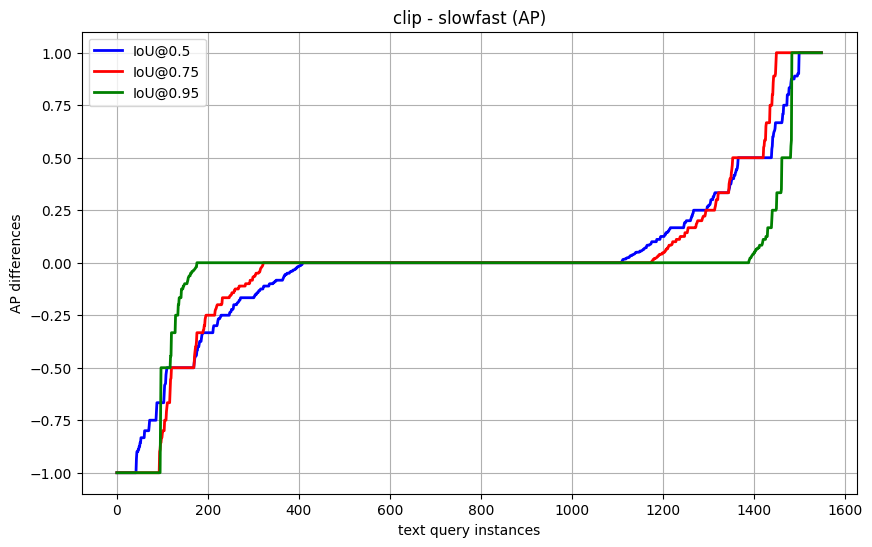

In [38]:
from matplotlib import pyplot as plt


plt.figure(figsize=(10,6))
plt.plot(x_idx, 
         np.sort(np.array(list(clip_slowfast['0.5'].values()))),
         linewidth=2,
         color='blue', 
        #  marker='o', 
        #  markerfacecolor='blue', 
        #  markersize=1
)

# plt.scatter(x_idx, 
#          np.sort(np.array(list(clip_slowfast['0.5'].values()))),
#         s = 1
# )

plt.plot(x_idx, 
         np.sort(np.array(list(clip_slowfast['0.75'].values()))),
         linewidth=2,
         color='red', 
        #  marker='o', 
        #  markerfacecolor='blue', 
        #  markersize=1
)

plt.plot(x_idx, 
         np.sort(np.array(list(clip_slowfast['0.95'].values()))),
         linewidth=2,
         color='green', 
        #  marker='o', 
        #  markerfacecolor='blue', 
        #  markersize=1
)

plt.title('clip - slowfast (AP)')
plt.xlabel('text query instances')
plt.ylabel('AP differences')
plt.grid(True)
plt.legend(('IoU@0.5', 'IoU@0.75', 'IoU@0.95'))


In [39]:
y_err = np.sort(np.array(list(clip_slowfast['0.5'].values())))

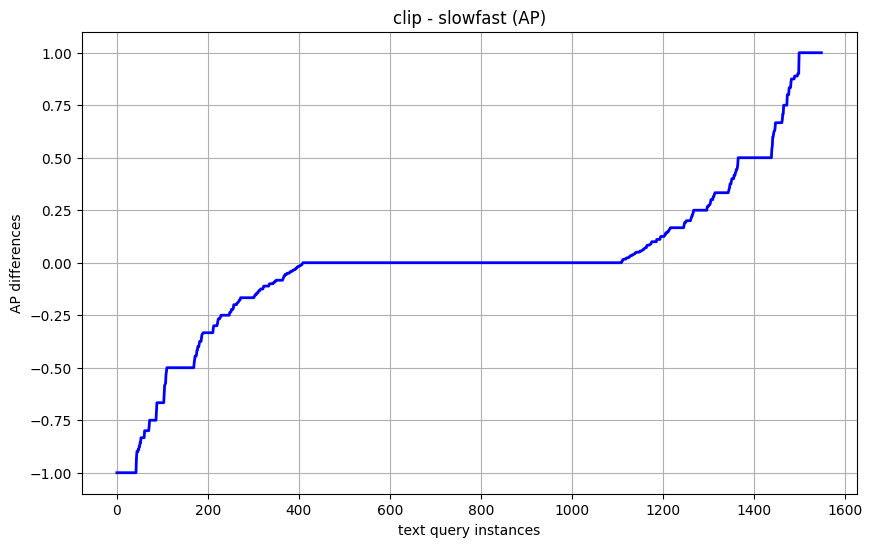

In [40]:
plt.figure(figsize=(10,6))
plt.plot(x_idx, 
         y_err,
         linewidth=2,
         color='blue', 
        #  marker='o', 
        #  markerfacecolor='blue', 
        #  markersize=1
)


plt.title('clip - slowfast (AP)')
plt.xlabel('text query instances')
plt.ylabel('AP differences')
plt.grid(True)


In [41]:
clip_slowfast_list = list(clip_slowfast['0.5'].items())

In [42]:
clip_slowfast_list

[(2579, 0.0),
 (5071, -1.0),
 (5342, 0.0),
 (8636, 1.0),
 (8749, -0.6666666666666667),
 (2638, -0.033333333333333326),
 (5979, 0.0),
 (6223, -0.875),
 (8737, 0.75),
 (8783, 0.9),
 (781, -0.8),
 (3359, 0.0),
 (3503, 0.0),
 (4625, 0.0),
 (7803, 0.0),
 (8056, 0.0),
 (2321, -1.0),
 (2343, 0.0),
 (5926, -0.6666666666666667),
 (9760, 0.0),
 (10029, 0.0),
 (10049, 0.0),
 (1872, 0.6666666666666666),
 (3389, 0.0),
 (8014, 0.0),
 (3183, 0.0),
 (3407, 0.0),
 (3525, 0.0),
 (3403, 0.16666666666666666),
 (4508, 0.0),
 (5612, 0.0),
 (9280, -0.25),
 (721, -0.8),
 (1870, 0.0),
 (2276, 0.0),
 (342, 0.0),
 (1751, 0.09999999999999999),
 (6083, -0.2),
 (7484, 0.0),
 (3001, 0.25),
 (5584, 0.1),
 (6746, 0.0),
 (9796, 0.0),
 (2585, -0.375),
 (3739, 0.0),
 (4854, 0.26666666666666666),
 (7218, 1.0),
 (8721, 1.0),
 (3069, 0.0),
 (4275, 0.0),
 (7735, 0.0),
 (4875, 0.5),
 (4887, 0.023809523809523808),
 (6213, 0.0),
 (7002, -0.125),
 (7555, 0.0),
 (2433, 0.0),
 (3584, 0.25),
 (4023, 1.0),
 (1961, -0.75),
 (4419, 0.

In [43]:
iou2diff = dict()

for idx, iou_thd in enumerate(iou_thds):

    iou2diff[iou_thd] = dict()

    for qid in slowfast_qid2ap_list.keys():
        iou2diff[iou_thd][qid] = [clip_qid2ap_list[qid][idx] - slowfast_qid2ap_list[qid][idx],
                                  both_qid2ap_list[qid][idx] - clip_qid2ap_list[qid][idx],
                                  both_qid2ap_list[qid][idx] - slowfast_qid2ap_list[qid][idx]]


In [44]:
iou_thd = '0.5'

diff_list = list(iou2diff[iou_thd].values())

y_clip_slowfast = [diff for diff, _, _ in sorted(diff_list, key=lambda x: x[0])]
y_both_clip = [diff for _, diff, _ in sorted(diff_list, key=lambda x: (x[0], -x[1]))]
y_both_slowfast = [diff for _, _, diff in sorted(diff_list, key=lambda x: (x[0], -x[2]))]

In [45]:
# sort_qid = [qid for qid, _ in clip_slowfast_list]

In [46]:
# y_clip_slowfast = [clip_slowfast['0.5'][qid] for qid in sort_qid]
# y_both_clip = [both_clip['0.5'][qid] for qid in sort_qid]
# y_both_slowfast = [both_slowfast['0.5'][qid] for qid in sort_qid]


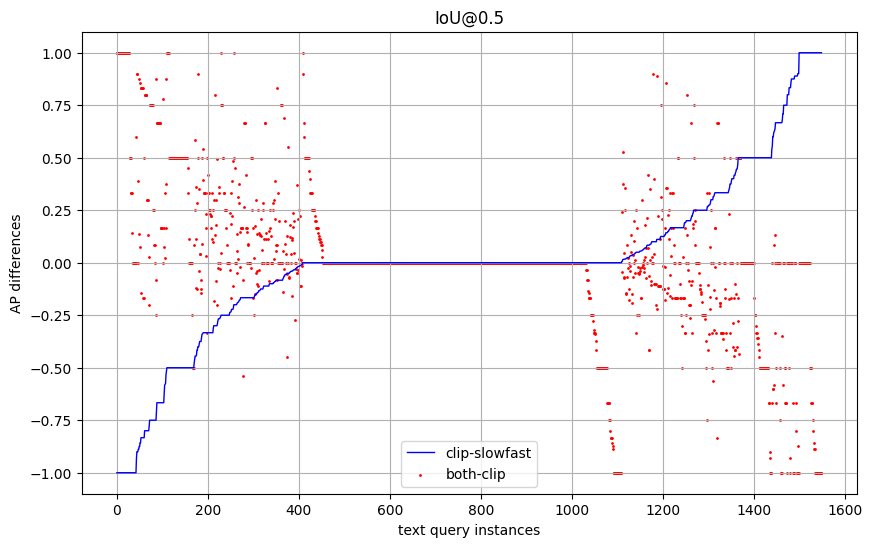

In [47]:
plt.figure(figsize=(10,6))
plt.plot(x_idx, 
         y_clip_slowfast,
         linewidth=1,
         color='blue', 
        #  marker='o', 
        #  markerfacecolor='blue', 
        #  markersize=1
)

plt.scatter(x_idx, 
         y_both_clip,
         s=1, c='red'
        #  linewidth=1,
        #  color='red', 
        #  marker='o', 
        #  markerfacecolor='blue', 
        #  markersize=1
)

# plt.plot(x_idx, 
#          y_both_slowfast,
#          linewidth=2,
#          color='green', 
#         #  marker='o', 
#         #  markerfacecolor='blue', 
#         #  markersize=1
# )

plt.title(f'IoU@{iou_thd}')
plt.xlabel('text query instances')
plt.ylabel('AP differences')
plt.grid(True)
plt.legend(('clip-slowfast', 'both-clip'))


In [56]:
y_slowfast_clip = [-i for i in  y_clip_slowfast]

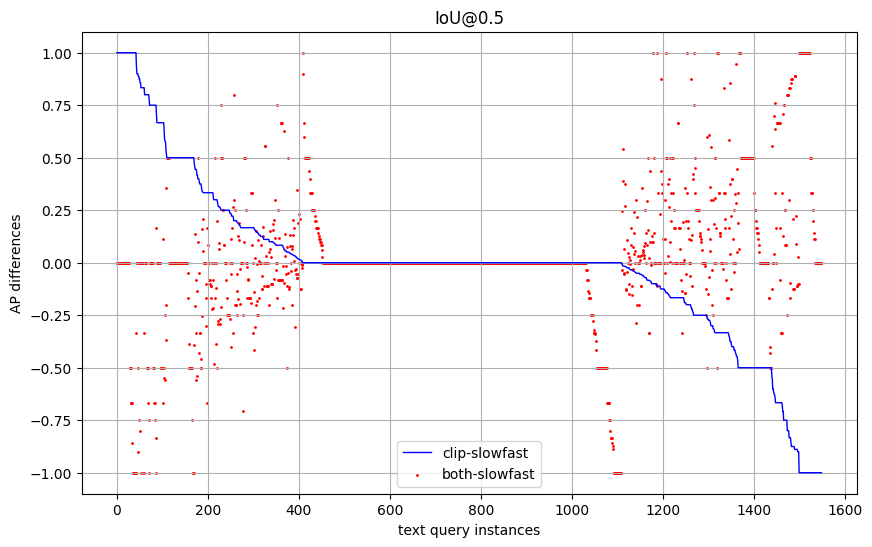

In [57]:
plt.figure(figsize=(10,6))
plt.plot(x_idx, 
         y_slowfast_clip,
         linewidth=1,
         color='blue', 
        #  marker='o', 
        #  markerfacecolor='blue', 
        #  markersize=1
)

plt.scatter(x_idx, 
         y_both_slowfast,
         s=1, c='red'
        #  linewidth=1,
        #  color='red', 
        #  marker='o', 
        #  markerfacecolor='blue', 
        #  markersize=1
)

plt.title(f'IoU@{iou_thd}')
plt.xlabel('text query instances')
plt.ylabel('AP differences')
plt.grid(True)
plt.legend(('clip-slowfast', 'both-slowfast'))

